We want to make some estamestions given some points in $2$D 

Start by loading in al the libarys.

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from Basis import *

import casadi as ca
import numpy as np
import random

Generating the points

 

<IPython.core.display.Javascript object>


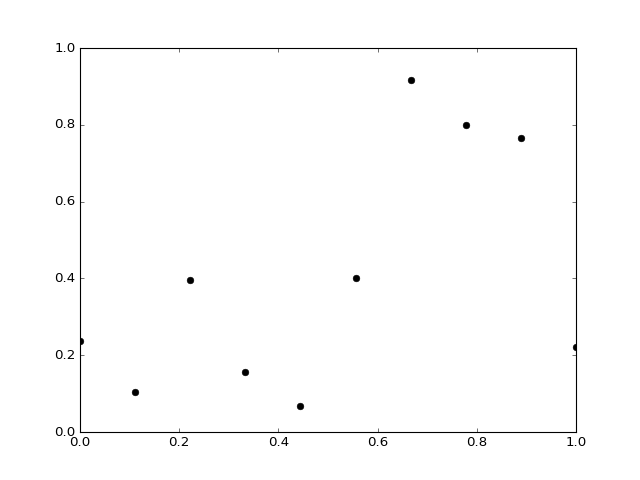

In [3]:
n = 10

x = [1.0*i/(n-1) for i in range(n) ]
random.seed(4)
y = [random.random() for _ in range(n)]

plt.figure()
plt.plot(x,y,'ko')

Construct the casadi problem

In [4]:
est   = ca.SX.sym('est',1)
bound   = ca.SX.sym('bound',1)

obj = bound

con = []
con_lower = []
con_upper = []

for x_,y_ in zip(x,y):
     con.append(est - bound)
     con_lower.append(-ca.inf)
     con_upper.append(y_)
    
     con.append(est + bound)
     con_lower.append(y_)
     con_upper.append(ca.inf)

nlp = { 'x':ca.vertcat(est, bound ),'f':obj,'g':ca.vertcat(*con) }
solver = ca.nlpsol("solver","ipopt", nlp)
r = solver(lbg = con_lower, ubg = con_upper)

print r


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

center value is  0.492235069624
distance to the bound is  0.425719968129


<IPython.core.display.Javascript object>


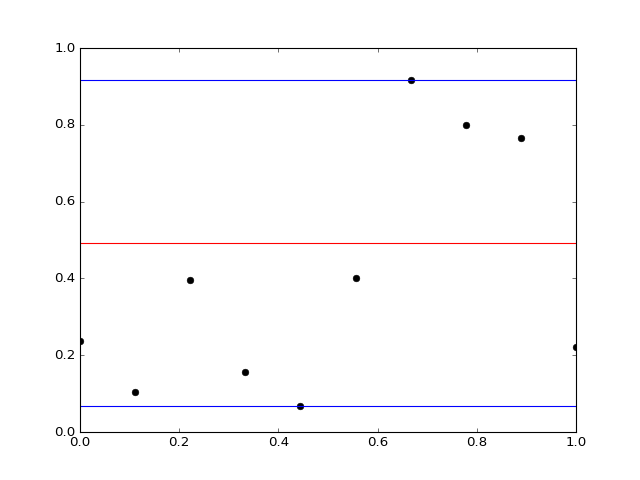

In [5]:
est_,bound_ = r['x'].full()
est_ = est_[0]
bound_ = bound_[0]
print "center value is ", str(est_)
print "distance to the bound is ", str(bound_)


upper_bound = 2 * [est_ + bound_]
lower_bound = 2 * [est_ - bound_]
middel = 2 * [est_]
interval = [0, 1]

plt.figure()
plt.plot(x,y,'ko')
plt.plot(interval,upper_bound,'b')
plt.plot(interval,lower_bound,'b')
plt.plot(interval,middel,'r')

Now we will try something simular but our estimation will be linear depending on $x$. To do this we will construct a Monomial and optimise over its coefficients.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      112
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:       10
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

<IPython.core.display.Javascript object>


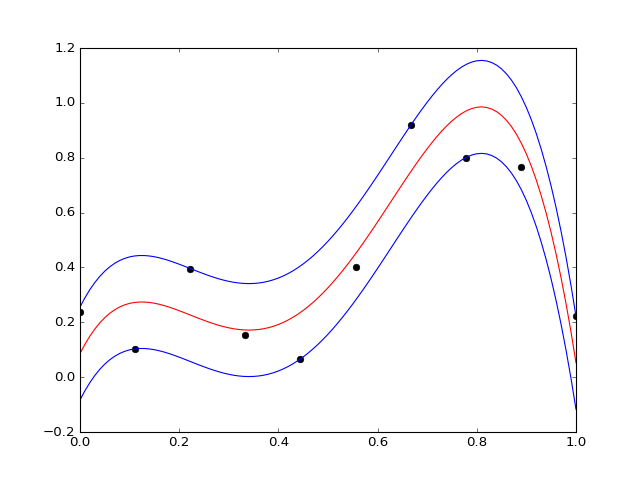

In [7]:
degree = 4
b = MonomialBasis(degree)

a_ = ca.SX.sym('a',degree + 1,1)
a = STensor(a_, [degree + 1,1,1])
a = Coefficient(a)

est_function = Function(b,a)

con = []
con_lower = []
con_upper = []

for x_,y_ in zip(x,y):    
     #con.append(est - bound)
     con.append(est_function([x_]).data() - bound)
     con_lower.append(-ca.inf)
     con_upper.append(y_)
    
     con.append(est_function([x_]).data() + bound)
     con_lower.append(y_)
     con_upper.append(ca.inf)
        
nlp = { 'x':ca.vertcat(a_, bound ),'f':obj,'g':ca.vertcat(*con) }
solver = ca.nlpsol("solver","ipopt", nlp)
r = solver(lbg = con_lower, ubg = con_upper)

est_ = r['x'].full()[0:degree+1]
bound_ = r['x'].full()[degree+1]
bound_ = bound_[0]
print "center value is ", str(est_)
print "distance to the bound is ", str(bound_)

a = est_
a = DTensor(a, [degree + 1,1,1])
a = Coefficient(a)

est_function = Function(b,a)

interval = np.linspace(0.,1.,101)
upper_bound = []
lower_bound = []
middel = []

for i in interval:
    upper_bound.append(est_function([i]).data() + bound_)
    lower_bound.append(est_function([i]).data() - bound_)
    middel.append(est_function([i]).data())

plt.figure()
plt.plot(x,y,'ko')
plt.plot(interval,upper_bound,'b')
plt.plot(interval,lower_bound,'b')
plt.plot(interval,middel,'r')

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       88
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:       10
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

<IPython.core.display.Javascript object>


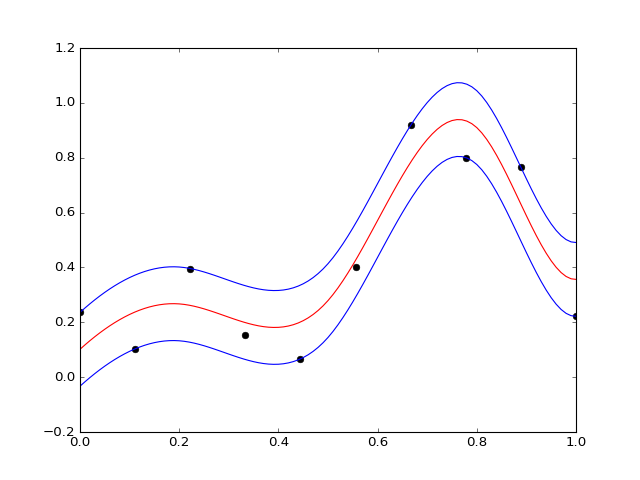

In [10]:
degree = 3
knots = (degree+1)*[0] + [0.2,0.5,0.8] + (degree+1)*[1]
m = SubBSplineBasis(knots ,degree)

b = Basis([m])


a_ = ca.SX.sym('a',m.getLenght(),1)
a = STensor(a_, [m.getLenght(),1,1])
a = Coefficient(a)
est_function = Function(b,a)
con = []
con_lower = []
con_upper = []

for x_,y_ in zip(x,y):
     con.append(est_function([x_]).data() - bound)
     con_lower.append(-ca.inf)
     con_upper.append(y_)
    
     con.append(est_function([x_]).data() + bound)
     con_lower.append(y_)
     con_upper.append(ca.inf)
        
nlp = { 'x':ca.vertcat(a_, bound ),'f':obj,'g':ca.vertcat(*con) }
solver = ca.nlpsol("solver","ipopt", nlp)
r = solver(lbg = con_lower, ubg = con_upper)
est_ = r['x'].full()[0:m.getLenght()]
bound_ = r['x'].full()[m.getLenght()]
bound_ = bound_[0]
a = est_
a = DTensor(a, [m.getLenght(),1,1])
a = Coefficient(a)
est_function = Function(b,a)
interval = np.linspace(0.,1.,101)
upper_bound = []
lower_bound = []
middel = []

for i in interval:
    upper_bound.append(est_function([i]).data() + bound_)
    lower_bound.append(est_function([i]).data() - bound_)
    middel.append(est_function([i]).data())

plt.figure()
plt.plot(x,y,'ko')
plt.plot(interval,upper_bound,'b')
plt.plot(interval,lower_bound,'b')
plt.plot(interval,middel,'r')

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

<IPython.core.display.Javascript object>


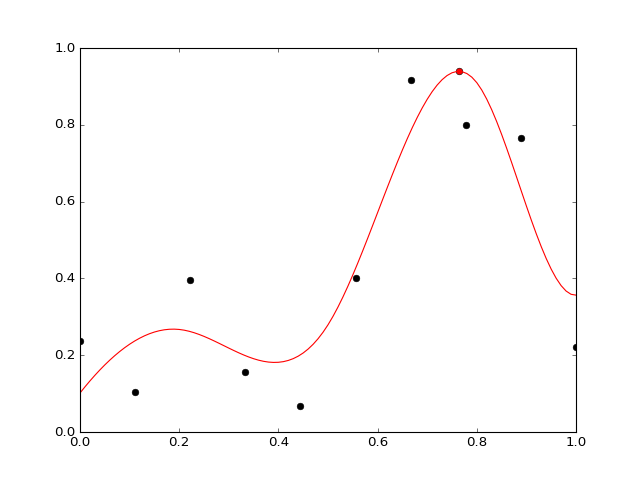

In [11]:
l = ca.SX.sym('l',1,1)
est_function([l]).data()

con = []
con_lower = []
con_upper = []
        
nlp = { 'x':l,'f':-est_function([l]).data()}
solver = ca.nlpsol("solver","ipopt", nlp)
r = solver(x0=0.6,lbg = con_lower, ubg = con_upper)

plt.figure()
plt.plot(x,y,'ko')
plt.plot([r['x']],[-r['f']],'ro')
plt.plot(interval,middel,'r')